In [ ]:

import json
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def load_data(filename="space_qa_dataset_large.json"):
    """Loads the dataset from a JSON file."""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data['data']

def preprocess_data(data):
    """
    Preprocesses the data to extract context, questions, and answers.
    Also, cleans the text and creates start/end token around answer.
    """

    contexts = []
    questions = []
    answers_text = [] # Store original answer texts
    answer_starts = [] # Store start positions of answers

    for topic in data:
        for paragraph in topic['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                answer = qa['answers'][0]  # Assuming one answer per question
                answer_text = answer['text']
                answer_start = context.find(answer_text)

                contexts.append(context)
                questions.append(question)
                answers_text.append(answer_text)
                answer_starts.append(answer_start)

    # Cleaning text (can be expanded)
    def clean_text(text):
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
        text = text.lower()
        return text

    contexts = [clean_text(c) for c in contexts]
    questions = [clean_text(q) for q in questions]

    # Create "target" which are the contexts with start/end tokens around answers
    targets = []
    for i in range(len(contexts)):
        target = contexts[i]
        start_idx = answer_starts[i]
        end_idx = start_idx + len(answers_text[i])
        target = target[:start_idx] + " <start> " + answers_text[i] + " <end> " + target[end_idx:]
        targets.append(clean_text(target)) # Clean the target as well

    return contexts, questions, targets

def tokenize_and_pad(contexts, questions, targets, max_len=100):
    """
    Tokenizes the contexts, questions, and answers and pads them to a maximum length.
    """

    # Tokenize contexts
    tokenizer_context = Tokenizer(oov_token="<OOV>")
    tokenizer_context.fit_on_texts(contexts)
    context_sequences = tokenizer_context.texts_to_sequences(contexts)
    padded_contexts = pad_sequences(context_sequences, maxlen=max_len, padding='post', truncating='post')

    # Tokenize questions
    tokenizer_question = Tokenizer(oov_token="<OOV>")
    tokenizer_question.fit_on_texts(questions)
    question_sequences = tokenizer_question.texts_to_sequences(questions)
    padded_questions = pad_sequences(question_sequences, maxlen=max_len, padding='post', truncating='post')

    # Tokenize targets
    tokenizer_target = Tokenizer(oov_token="<OOV>", filters='') # Important: No filters for <start> and <end>
    tokenizer_target.fit_on_texts(targets)
    target_sequences = tokenizer_target.texts_to_sequences(targets)
    padded_targets = pad_sequences(target_sequences, maxlen=max_len, padding='post', truncating='post')

    return padded_contexts, padded_questions, padded_targets, tokenizer_context, tokenizer_question, tokenizer_target

# --- Main execution ---
data = load_data()
contexts, questions, targets = preprocess_data(data)

# You can adjust max_len as needed
padded_contexts, padded_questions, padded_targets, tokenizer_context, tokenizer_question, tokenizer_target = tokenize_and_pad(
    contexts, questions, targets, max_len=200
)

# Vocabulary sizes (for embedding layers)
context_vocab_size = len(tokenizer_context.word_index) + 1
question_vocab_size = len(tokenizer_question.word_index) + 1
target_vocab_size = len(tokenizer_target.word_index) + 1

# Split data (adjust test_size as needed)
context_train, context_test, question_train, question_test, target_train, target_test = train_test_split(
    padded_contexts, padded_questions, padded_targets, test_size=0.2, random_state=42
)

print("Data Preprocessing Done.")

Data Preprocessing Done.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

def create_model(context_vocab_size, question_vocab_size, target_vocab_size, max_len, embedding_dim=64, lstm_units=256):
    """
    Creates the LSTM encoder-decoder model with Bahdanau attention (fixed dimension issue).

    Args:
        context_vocab_size: Vocabulary size of the context.
        question_vocab_size: Vocabulary size of the question.
        target_vocab_size: Vocabulary size of the target.
        max_len: Maximum sequence length.
        embedding_dim: Dimensionality of the embedding layers.
        lstm_units: Number of units in the LSTM layers.

    Returns:
        The compiled Keras model.
    """

    # ------------------- Encoder -------------------
    # Context input
    context_input = Input(shape=(max_len,), name='context_input')
    context_embedding = Embedding(context_vocab_size, embedding_dim, name='context_embedding')(context_input)
    context_encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, name='context_encoder_lstm')(context_embedding)
    context_encoder_outputs, context_encoder_h, context_encoder_c = context_encoder_lstm

    # Question input
    question_input = Input(shape=(max_len,), name='question_input')
    question_embedding = Embedding(question_vocab_size, embedding_dim, name='question_embedding')(question_input)
    question_encoder_lstm = LSTM(lstm_units, return_state=True, name='question_encoder_lstm')(question_embedding)
    question_encoder_outputs_q, question_encoder_h, question_encoder_c = question_encoder_lstm # Separate output for question

    # Concatenate the final states of both encoders to initialize the decoder
    encoder_final_state_h = Concatenate(axis=-1, name='encoder_final_state_h')([context_encoder_h, question_encoder_h])
    encoder_final_state_c = Concatenate(axis=-1, name='encoder_final_state_c')([context_encoder_c, question_encoder_c])

    # Project encoder outputs to match decoder output dimension
    encoder_outputs_processed = Dense(lstm_units * 2, activation='relu', name='encoder_output_projection')(context_encoder_outputs)

    # ------------------- Decoder -------------------
    target_input = Input(shape=(max_len,), name='target_input')
    target_embedding = Embedding(target_vocab_size, embedding_dim, name='target_embedding')(target_input)
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True, name='decoder_lstm')(
        target_embedding, initial_state=[encoder_final_state_h, encoder_final_state_c]
    )
    decoder_outputs, _, _ = decoder_lstm

    # ------------------- Attention Mechanism (Bahdanau) -------------------
    attention = Attention(name='attention')([decoder_outputs, encoder_outputs_processed])  # decoder_outputs (query), processed encoder_outputs (value)
    context_vector = Concatenate(axis=-1, name='context_vector')([decoder_outputs, attention])

    # Output layer
    output = Dense(target_vocab_size, activation='softmax', name='output')(context_vector)

    # Define the model
    model = Model(inputs=[context_input, question_input, target_input], outputs=output) # Only output prediction here

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# --- Re-create and Print Model Summary ---
model = create_model(
    context_vocab_size, question_vocab_size, target_vocab_size, max_len=padded_contexts.shape[1],
    embedding_dim=128, lstm_units=256 # Using the same units
)
model.summary()

print("Model Architecture Defined.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_input       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_input      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_embedding   │ (None, 200, 128)  │     17,280 │ context_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_embedding  │ (None, 200, 128)  │     11,136 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_input        │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_encoder_ls… │ [(None, 200,      │    394,240 │ context_embeddin… │
│ (LSTM)              │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ question_encoder_l… │ [(None, 256),     │    394,240 │ question_embeddi… │
│ (LSTM)              │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_embedding    │ (None, 200, 128)  │     28,544 │ target_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_final_stat… │ (None, 512)       │          0 │ context_encoder_… │
│ (Concatenate)       │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_final_stat… │ (None, 512)       │          0 │ context_encoder_… │
│ (Concatenate)       │                   │            │ question_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 200,      │  1,312,768 │ target_embedding… │
│                     │ 512), (None,      │            │ encoder_final_st… │
│                     │ 512), (None,      │            │ encoder_final_st… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output_pro… │ (None, 200, 512)  │    131,584 │ context_encoder_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 200, 512)  │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_output_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 200, 1024) │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 200, 223)  │    228,575 │ context_vector[0… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 2,518,367 (9.61 MB)

 Trainable params: 2,518,367 (9.61 MB)

 Non-trainable params: 0 (0.00 B)

Model Architecture Defined.


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step - accuracy: 0.3163 - loss: 4.8952 - val_accuracy: 0.6227 - val_loss: 2.7370
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6303 - loss: 2.3620 - val_accuracy: 0.6271 - val_loss: 1.9610
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6326 - loss: 1.9048 - val_accuracy: 0.6285 - val_loss: 1.8711
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6468 - loss: 1.7930 - val_accuracy: 0.6444 - val_loss: 1.8292
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6521 - loss: 1.7826 - val_accuracy: 0.6438 - val_loss: 1.7797
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6542 - loss: 1.7413 - val_accuracy: 0.6446 - val_loss: 1.7481
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6489 - loss: 1.7152 - val_accuracy: 0.6437 - val_loss: 1.7105
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6491 - loss: 1.6797 - val_accuracy: 0.6447 - val_loss:

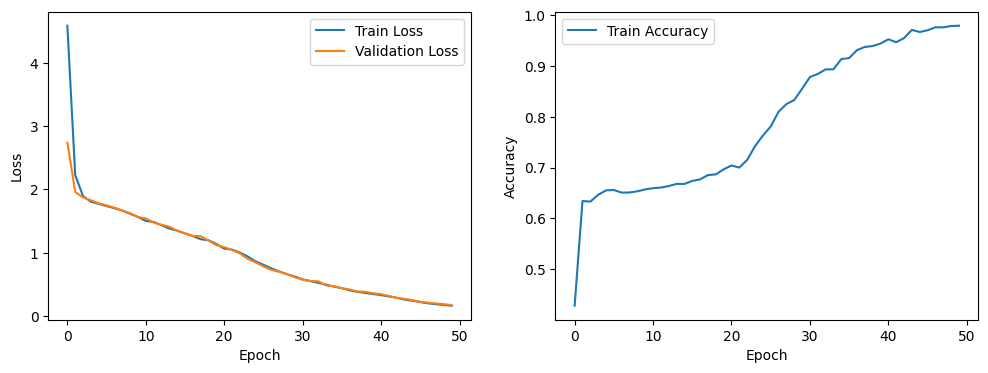

In [ ]:
epochs = 50
batch_size = 64

history = model.fit(
    [context_train, question_train, target_train],
    np.expand_dims(target_train, axis=-1),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([context_test, question_test, target_test], np.expand_dims(target_test, axis=-1))
)

import matplotlib.pyplot as plt

# --- Plotting training history ---
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
from tensorflow.keras.models import load_model

# --- Load the saved model ---
model = load_model('qa_model_with_attention.h5')
print("Main QA model loaded.")

Main QA model loaded.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np  # Import numpy
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict(model, context, question, tokenizer_context, tokenizer_question, tokenizer_target, max_len):  # Remove default max_len
    """
    Generates an answer given a context and a question.

    Args:
        model: The trained Keras model.
        context: The input context (string).
        question: The input question (string).
        tokenizer_context: Tokenizer for the context.
        tokenizer_question: Tokenizer for the question.
        tokenizer_target: Tokenizer for the target.
        max_len: Maximum length of the input sequences (from training).

    Returns:
        The predicted answer (string).
    """

    # Preprocess the input
    context = clean_text(context)
    question = clean_text(question)

    context_seq = tokenizer_context.texts_to_sequences([context])
    padded_context = pad_sequences(context_seq, maxlen=max_len, padding='post', truncating='post')

    question_seq = tokenizer_question.texts_to_sequences([question])
    padded_question = pad_sequences(question_seq, maxlen=max_len, padding='post', truncating='post')

    # Prepare the target input (start with <start> token)
    target_seq = tokenizer_target.texts_to_sequences(["<start>"])
    padded_target = pad_sequences(target_seq, maxlen=max_len, padding='post', truncating='post')

    # Prediction loop
    for i in range(max_len - 1):  # Change the loop condition
        prediction = model.predict([padded_context, padded_question, padded_target], verbose=0)
        print(f"Prediction shape: {prediction.shape}, i: {i}")  # Debugging: Check prediction shape
        print(f"Raw prediction: {prediction[0, i, :10]}")  # Debugging: Check raw output
        predicted_token_index = np.argmax(prediction[0, i])
        predicted_token = tokenizer_target.index_word.get(predicted_token_index, "<OOV>")

        if predicted_token == "<end>":
            break

        padded_target[0, i + 1] = predicted_token_index

    # Decode the predicted sequence
    predicted_answer_tokens = [tokenizer_target.index_word.get(idx, "<OOV>") for idx in padded_target[0] if idx != 0]
    predicted_answer = " ".join(predicted_answer_tokens)
    predicted_answer = predicted_answer.replace("<start> ", "").replace(" <end>", "").strip()

    return predicted_answer

print("Prediction Function Defined.")

# --- Example Usage for Visualization ---
context_example = "The solar system has eight planets: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune. Mercury is the closest to the Sun."
question_example = "What is the closest planet to the Sun?"
target_example = "mercury"  # Cleaned version

predicted_answer_example = predict(model, context_example, question_example, tokenizer_context, tokenizer_question, tokenizer_target, max_len=padded_contexts.shape[1])

print("--- Prediction Debugging ---")
print(f"Context: {context_example}")
print(f"Question: {question_example}")
print(f"Predicted Answer: {predicted_answer_example}")
print("--------------------------")

Prediction Function Defined.


NameError: name 'clean_text' is not defined

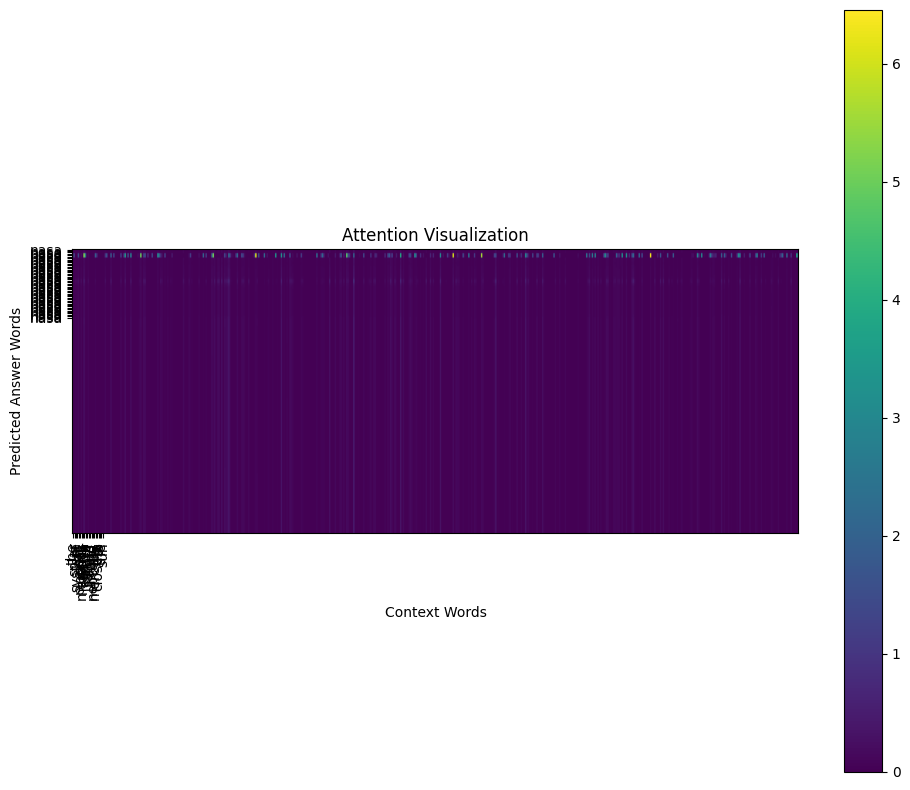

Attention Visualization Done.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def visualize_attention(context, question, predicted_answer, attention_scores, tokenizer_context, tokenizer_target):
    """
    Visualizes the attention weights.

    Args:
        context: The input context (string).
        question: The input question (string).
        predicted_answer: The predicted answer (string).
        attention_scores: The attention scores from the model.
        tokenizer_context: Tokenizer for the context.
        tokenizer_target: Tokenizer for the target.
    """

    context_tokens = tokenizer_context.texts_to_sequences([context])[0]
    context_words = [tokenizer_context.index_word.get(idx, "<OOV>") for idx in context_tokens if idx != 0]

    predicted_answer_tokens = tokenizer_target.texts_to_sequences([predicted_answer])[0]
    predicted_answer_words = [tokenizer_target.index_word.get(idx, "<OOV>") for idx in predicted_answer_tokens if idx != 0]

    # Assuming attention_scores has shape (batch, target_seq_len, context_seq_len)
    attention_matrix = attention_scores[0]

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_matrix, cmap='viridis')
    plt.xticks(range(len(context_words)), context_words, rotation='vertical')
    plt.yticks(range(len(predicted_answer_words)), predicted_answer_words)
    plt.xlabel("Context Words")
    plt.ylabel("Predicted Answer Words")
    plt.title("Attention Visualization")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# --- Example Usage for Visualization ---
context_example = "The solar system has eight planets: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune. Mercury is the closest to the Sun."
question_example = "What is the closest planet to the Sun?"
target_example = "mercury" # Cleaned version

predicted_answer_example = predict(model, context_example, question_example, tokenizer_context, tokenizer_question, tokenizer_target, max_len=padded_contexts.shape[1])

# Get attention scores
context_seq = tokenizer_context.texts_to_sequences([context_example])
padded_context_example = pad_sequences(context_seq, maxlen=padded_contexts.shape[1], padding='post', truncating='post')

question_seq = tokenizer_question.texts_to_sequences([question_example])
padded_question_example = pad_sequences(question_seq, maxlen=padded_questions.shape[1], padding='post', truncating='post')

target_seq = tokenizer_target.texts_to_sequences(["<start>"])
padded_target_example = pad_sequences(target_seq, maxlen=padded_targets.shape[1], padding='post', truncating='post')

# We need to run the prediction step by step to get attention scores for each output token
predicted_answer_tokens_with_start = ["<start>"]
attention_scores_list = []

# Create a new model to get attention scores
attention_layer = model.get_layer('attention')
attention_model_for_prediction = Model(inputs=model.input, outputs=[model.output, attention_layer.output])

for i in range(50): # max_len
    target_input_seq = tokenizer_target.texts_to_sequences([predicted_answer_tokens_with_start[-1]])
    padded_target_input = pad_sequences(target_input_seq, maxlen=padded_targets.shape[1], padding='post', truncating='post')

    output, attention_output = attention_model_for_prediction.predict([padded_context_example, padded_question_example, padded_target_input], verbose=0)
    predicted_token_index = np.argmax(output[0, 0])
    predicted_token = tokenizer_target.index_word.get(predicted_token_index, "<OOV>")

    attention_scores_list.append(attention_output[0])  # Store attention scores for this step

    predicted_answer_tokens_with_start.append(predicted_token)

    if predicted_token == "<end>":
        break

predicted_answer_for_visualization = " ".join(predicted_answer_tokens_with_start[1:-1]) # Exclude <start> and <end>

if attention_scores_list:
    visualize_attention(context_example, question_example, predicted_answer_for_visualization, np.array(attention_scores_list), tokenizer_context, tokenizer_target)
else:
    print("Attention scores were not retrieved.")

print("Attention Visualization Done.")

In [ ]:
# --- Save the main model ---
model.save('qa_model_with_attention.h5')
print("Main QA model saved as qa_model_with_attention.h5")

Main QA model saved as qa_model_with_attention.h5


In [ ]:
!pip install rouge
!pip install nltk

In [ ]:
from collections import Counter
import re
import time
import numpy as np
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
import nltk
import nltk.tokenize

nltk.download('wordnet')

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    if not isinstance(s, str):
        s = str(s)
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return re.sub(r'[^\w\s]', '', text)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def compute_f1(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_rouge(prediction, ground_truth):
    rouge = Rouge()
    try:
        scores = rouge.get_scores(prediction, ground_truth)
        return scores[0]['rouge-l']['f']
    except ValueError:
        return 0.0

def compute_bleu(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = [normalize_answer(ground_truth).split()]
    try:
        return sentence_bleu(ground_truth_tokens, prediction_tokens)
    except ValueError:
        return 0.0

def compute_meteor(prediction, ground_truth):
    try:
        prediction_tokens = nltk.tokenize.word_tokenize(normalize_answer(prediction))  # Tokenize prediction
        return single_meteor_score(normalize_answer(ground_truth), prediction_tokens)
    except (LookupError, ValueError):
        return 0.0

def find_answer_span(context, target):
    """Finds the span of the answer within the context, handling errors."""
    context = normalize_answer(context)
    target = normalize_answer(target)
    start_idx = context.find(target)
    if start_idx == -1:
        context_tokens = context.split()
        target_tokens = target.split()
        best_start_idx = -1
        max_match = 0
        for i in range(len(context_tokens) - len(target_tokens) + 1):
            match_count = sum(1 for j in range(len(target_tokens)) if context_tokens[i + j] == target_tokens[j])
            if match_count > max_match:
                max_match = match_count
                best_start_idx = len(" ".join(context_tokens[:i])) + (1 if i > 0 else 0)

        if best_start_idx == -1:
            return ""
        else:
            return context[best_start_idx:best_start_idx + len(target)]
    else:
        return context[start_idx:start_idx + len(target)]

def evaluate(model, contexts, questions, answers, tokenizer_context, tokenizer_question, tokenizer_target, max_len):
    """
    Evaluates the model on the given data, including ROUGE, BLEU, METEOR, and inference time.
    """

    exact_match_scores = []
    f1_scores = []
    rouge_scores = []
    bleu_scores = []
    meteor_scores = []
    inference_times = []

    for i in range(len(questions)):
        context = str(contexts[i])
        question = str(questions[i])
        ground_truth = str(answers[i])

        start_time = time.time()
        predicted_answer = predict(model, context, question, tokenizer_context, tokenizer_question, tokenizer_target, max_len)
        end_time = time.time()
        inference_time = end_time - start_time

        answer_span = find_answer_span(context, ground_truth)

        exact_match = compute_exact_match(predicted_answer, answer_span)
        f1 = compute_f1(predicted_answer, answer_span)
        rouge = compute_rouge(predicted_answer, answer_span)
        bleu = compute_bleu(predicted_answer, answer_span)
        meteor = compute_meteor(predicted_answer, answer_span)

        exact_match_scores.append(exact_match)
        f1_scores.append(f1)
        rouge_scores.append(rouge)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        inference_times.append(inference_time)

    average_exact_match = sum(exact_match_scores) / len(exact_match_scores)
    average_f1 = sum(f1_scores) / len(f1_scores)
    average_rouge = sum(rouge_scores) / len(rouge_scores)
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    average_meteor = sum(meteor_scores) / len(meteor_scores)
    average_inference_time = sum(inference_times) / len(inference_times)

    return {
        'exact_match': average_exact_match,
        'f1': average_f1,
        'rouge': average_rouge,
        'bleu': average_bleu,
        'meteor': average_meteor,
        'average_inference_time': average_inference_time
    }

# --- Example Usage ---
# Assuming you have context_test, question_test, answers_test
# which are lists of strings corresponding to your test set.
answers_test = []
for i in range(len(context_test)):
    context = str(context_test[i])
    target = str(targets[i])
    answers_test.append(target)

evaluation_results = evaluate(model, context_test, question_test, answers_test, tokenizer_context, tokenizer_question, tokenizer_target, max_len=padded_contexts.shape[1])

print("Evaluation Results:")
print(f"Exact Match: {evaluation_results['exact_match']:.4f}")
print(f"F1 Score: {evaluation_results['f1']:.4f}")
print(f"ROUGE-L: {evaluation_results['rouge']:.4f}")
print(f"BLEU: {evaluation_results['bleu']:.4f}")
print(f"METEOR: {evaluation_results['meteor']:.4f}")
print(f"Average Inference Time: {evaluation_results['average_inference_time']:.4f} seconds")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

In [ ]:
import nltk

nltk.download('punkt')  # Download the Punkt tokenizer data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from collections import Counter
import re
import time
import numpy as np
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
import nltk
import nltk.tokenize

nltk.download('wordnet')
nltk.download('punkt')

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    if not isinstance(s, str):
        print(f"normalize_answer: Input is not a string, converting: {type(s)}")
        s = str(s)
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return re.sub(r'[^\w\s]', '', text)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, ground_truth):
    print(f"compute_exact_match: prediction type = {type(prediction)}, ground_truth type = {type(ground_truth)}")
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def compute_f1(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_rouge(prediction, ground_truth):
    rouge = Rouge()
    try:
        scores = rouge.get_scores(prediction, ground_truth)
        return scores[0]['rouge-l']['f']
    except ValueError:
        return 0.0

def compute_bleu(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = [normalize_answer(ground_truth).split()]
    try:
        return sentence_bleu(ground_truth_tokens, prediction_tokens)
    except ValueError:
        return 0.0

def compute_meteor(prediction, ground_truth):
    try:
        prediction_tokens = nltk.tokenize.word_tokenize(normalize_answer(prediction))
        print(f"compute_meteor: prediction_tokens type = {type(prediction_tokens)}, ground_truth type = {type(ground_truth)}")
        return single_meteor_score(normalize_answer(ground_truth), prediction_tokens)
    except (LookupError, ValueError, TypeError) as e:
        print(f"compute_meteor error: {e}")
        return 0.0

def find_answer_span(context, target):
    """Finds the span of the answer within the context, handling errors."""
    if not isinstance(context, str):
        print(f"find_answer_span: context is not a string, converting: {type(context)}")
        context = str(context)
    if not isinstance(target, str):
        print(f"find_answer_span: target is not a string, converting: {type(target)}")
        target = str(target)
    context = normalize_answer(context)
    target = normalize_answer(target)
    start_idx = context.find(target)
    if start_idx == -1:
        context_tokens = context.split()
        target_tokens = target.split()
        best_start_idx = -1
        max_match = 0
        for i in range(len(context_tokens) - len(target_tokens) + 1):
            match_count = sum(1 for j in range(len(target_tokens)) if context_tokens[i + j] == target_tokens[j])
            if match_count > max_match:
                max_match = match_count
                best_start_idx = len(" ".join(context_tokens[:i])) + (1 if i > 0 else 0)

        if best_start_idx == -1:
            return ""
        else:
            return context[best_start_idx:best_start_idx + len(target)]
    else:
        return context[start_idx:start_idx + len(target)]

def evaluate(model, contexts, questions, answers, tokenizer_context, tokenizer_question, tokenizer_target, max_len):
    """
    Evaluates the model on the given data, including ROUGE, BLEU, METEOR, and inference time.
    """

    exact_match_scores = []
    f1_scores = []
    rouge_scores = []
    bleu_scores = []
    meteor_scores = []
    inference_times = []

    num_examples = 5  # Reduce to 5 for even faster debugging

    for i in range(min(num_examples, len(questions))):
        context = str(contexts[i])
        question = str(questions[i])
        ground_truth = str(answers[i])

        print(f"evaluate: Processing example {i}, context type = {type(context)}, question type = {type(question)}, ground_truth type = {type(ground_truth)}")

        start_time = time.time()
        predicted_answer = predict(model, context, question, tokenizer_context, tokenizer_question, tokenizer_target, max_len)
        end_time = time.time()
        inference_time = end_time - start_time

        answer_span = find_answer_span(context, ground_truth)

        # *** INSPECTION: Print predicted and ground truth answers ***
        print(f"  --- Example {i} ---")
        print(f"  Predicted Answer: '{predicted_answer}'")
        print(f"  Ground Truth Span: '{answer_span}'")
        # *********************************************************

        exact_match = compute_exact_match(predicted_answer, answer_span)
        f1 = compute_f1(predicted_answer, answer_span)
        rouge = compute_rouge(predicted_answer, answer_span)
        bleu = compute_bleu(predicted_answer, answer_span)
        meteor = compute_meteor(predicted_answer, answer_span)

        exact_match_scores.append(exact_match)
        f1_scores.append(f1)
        rouge_scores.append(rouge)
        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        inference_times.append(inference_time)

    average_exact_match = sum(exact_match_scores) / len(exact_match_scores) if exact_match_scores else 0
    average_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    average_rouge = sum(rouge_scores) / len(rouge_scores) if rouge_scores else 0
    average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    average_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    average_inference_time = sum(inference_times) / len(inference_times) if inference_times else 0

    return {
        'exact_match': average_exact_match,
        'f1': average_f1,
        'rouge': average_rouge,
        'bleu': average_bleu,
        'meteor': average_meteor,
        'average_inference_time': average_inference_time
    }

# --- Example Usage ---
# Assuming you have context_test, question_test, answers_test
# which are lists of strings corresponding to your test set.
answers_test = []
num_examples = 5  # Reduce for consistency
for i in range(min(num_examples, len(context_test))):
    context = str(context_test[i])
    target = str(targets[i])
    answers_test.append(target)

# Slice the test data to match the number of examples we're evaluating
context_test_subset = context_test[:num_examples]
question_test_subset = question_test[:num_examples]
answers_test_subset = answers_test[:num_examples]

evaluation_results = evaluate(model, context_test_subset, question_test_subset, answers_test_subset, tokenizer_context, tokenizer_question, tokenizer_target, max_len=padded_contexts.shape[1])

print("Evaluation Results:")
print(f"Exact Match: {evaluation_results['exact_match']:.4f}")
print(f"F1 Score: {evaluation_results['f1']:.4f}")
print(f"ROUGE-L: {evaluation_results['rouge']:.4f}")
print(f"BLEU: {evaluation_results['bleu']:.4f}")
print(f"METEOR: {evaluation_results['meteor']:.4f}")
print(f"Average Inference Time: {evaluation_results['average_inference_time']:.4f} seconds")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


evaluate: Processing example 0, context type = <class 'str'>, question type = <class 'str'>, ground_truth type = <class 'str'>
  --- Example 0 ---
  Predicted Answer: '<OOV> holes holes holes formed from collapsed have gravitational pulls strong that not even light can escape are are found found in in in in different different sizes sizes sizes intermediate intermediate supermassiv supermassiv supermassiv supermassiv supermassiv at explosion humans dying star star star star apollo apollo apollo moon moon voyager voyager gravitational so so that that not even light can escape escape are are found found in in in in in different different sizes sizes sizes intermediate intermediate supermassiv supermassiv supermassiv supermassiv at at at humans humans star star star star apollo apollo apollo apollo landings landings landings gravitational so so that that not even light can escape escape are are found found in in in in in different different sizes sizes sizes intermediate intermediate supe